In [1]:
using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=10)

safemul(x, y) = x == 0 ? zero(x*y) : isinf(x) ? oftype(x*y, Inf) : x*y
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(x/y) : x/y

x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_oddsratio_wald(a, b, c, d; OR=1.0)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    ccdf(Chisq(1), (logORhat - log(OR))^2/SEhat_logORhat^2)
end

function confint_oddsratio_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_oddsratio_wald (generic function with 1 method)

In [3]:
function delta(a, b, c, d; OR=1.0)
    A, B, C = 1-OR, a+d+OR*(b+c), a*d-OR*b*c
    isinf(OR) ? oftype(OR, -min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_oddsratio(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_oddsratio(a, b, c, d; OR=1.0, correction=0.0)
    δ = delta(a, b, c, d; OR)
    _chisqstat_oddsratio(a, b, c, d, δ; correction)
end

function pvalue_oddsratio_pearson_chisq(a, b, c, d; OR=1.0, correction=0.0)
    χ² = chisqstat_oddsratio(a, b, c, d; OR, correction)
    ccdf(Chisq(1), χ²)
end

function confint_oddsratio_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logOR) = logit(pvalue_oddsratio_pearson_chisq(a, b, c, d; OR=exp(logOR), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        OR_L, OR_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(OR_L))), exp(find_zero(f, log(OR_U)))]
    end
end

confint_oddsratio_pearson_chisq (generic function with 1 method)

In [4]:
function _gstat_oddsratio(a, b, c, d, δ)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    2(
        safemul(a, log(safediv(a, ã))) +
        safemul(b, log(safediv(b, b̃))) +
        safemul(c, log(safediv(c, c̃))) +
        safemul(d, log(safediv(d, d̃)))
    )
end

# firth = 0.5 はFirth補正を与える.
function gstat_oddsratio(a, b, c, d; OR=1.0, firth=0.5)
    af, bf, cf, df = a+firth, b+firth, c+firth, d+firth
    δ = delta(af, bf, cf, df; OR)
    _gstat_oddsratio(af, bf, cf, df, δ)
end

function pvalue_oddsratio_gtest(a, b, c, d; OR=1.0, firth=0.5)
    χ² = gstat_oddsratio(a, b, c, d; OR, firth)
    ccdf(Chisq(1), χ²)
end

pvalue_oddsratio_gtest (generic function with 1 method)

In [5]:
_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_fisher_minlik(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_oddsratio_fisher_minlik(a, b, c, d; OR=1)
    fnch = if OR == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, OR)
    end
    pvalue_fisher_minlik(fnch, a)
end

function find_pos(f, x)
    while f(x) ≤ 0
        x *= 2
    end
    x
end

function confint_oddsratio_fisher_minlik(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logOR) = logit(pvalue_oddsratio_fisher_minlik(a, b, c, d; OR=exp(logOR))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, (find_pos(f, -1.0), 0.0)))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, (0.0, find_pos(f, 1.0)))), Inf]
    else
        OR_L, OR_U = confint_or_wald(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(OR_L), log(OR_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end


confint_oddsratio_fisher_minlik (generic function with 1 method)

pvalue_oddsratio_fisher_minlik(A...; OR = 1.0) = 0.05428177406897716
pvalue_oddsratio_gtest(A...; OR = 1.0) = 0.046776593664974
pvalue_oddsratio_pearson_chisq(A...; OR = 1.0) = 0.042891212752040477
pvalue_oddsratio_wald(A...; OR = 1.0) = 0.04752707143814079


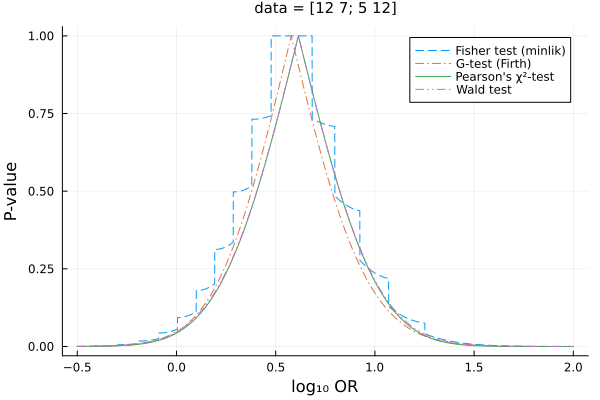

In [6]:
A = [
    12 7
    5 12
]

for method in (:fisher_minlik, :gtest, :pearson_chisq, :wald)
    fname = Symbol(:pvalue_oddsratio_, method)
    @eval @show $fname(A...; OR=1.0)
end
plot(log₁₀OR -> pvalue_oddsratio_fisher_minlik(A...; OR=10^log₁₀OR), -0.5, 2; label="Fisher test (minlik)", ls=:dash)
plot!(log₁₀OR -> pvalue_oddsratio_gtest(A...; OR=10^log₁₀OR); label="G-test (Firth)", ls=:dashdot)
plot!(log₁₀OR -> pvalue_oddsratio_pearson_chisq(A...; OR=10^log₁₀OR); label="Pearson's χ²-test", ls=:solid)
plot!(log₁₀OR -> pvalue_oddsratio_wald(A...; OR=10^log₁₀OR); label="Wald test", ls=:dashdotdot)
plot!(xguide="log₁₀ OR", yguide="P-value")
title!("data = $A")

pvalue_oddsratio_fisher_minlik(A...; OR = 1.0) = 0.060139860139860175
pvalue_oddsratio_gtest(A...; OR = 1.0) = 0.043898983241690226
pvalue_oddsratio_pearson_chisq(A...; OR = 1.0) = 0.03614983237685893
pvalue_oddsratio_wald(A...; OR = 1.0) = 0.05425433216022145


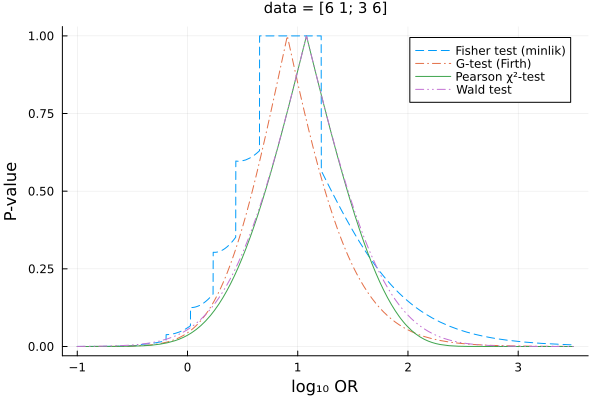

In [7]:
A = [
    6 1
    3 6
]

for method in (:fisher_minlik, :gtest, :pearson_chisq, :wald)
    fname = Symbol(:pvalue_oddsratio_, method)
    @eval @show $fname(A...; OR=1.0)
end
plot(log₁₀OR -> pvalue_oddsratio_fisher_minlik(A...; OR=10^log₁₀OR), -1, 3.5; label="Fisher test (minlik)", ls=:dash)
plot!(log₁₀OR -> pvalue_oddsratio_gtest(A...; OR=10^log₁₀OR); label="G-test (Firth)", ls=:dashdot)
plot!(log₁₀OR -> pvalue_oddsratio_pearson_chisq(A...; OR=10^log₁₀OR); label="Pearson χ²-test", ls=:solid)
plot!(log₁₀OR -> pvalue_oddsratio_wald(A...; OR=10^log₁₀OR); label="Wald test", ls=:dashdotdot)
plot!(xguide="log₁₀ OR", yguide="P-value")
title!("data = $A")